# Build convrnn

So we've downloaded the dataset and analyzed and visualized it. We're ready now for the next step: building the convrnn.

We first test it with a synthetic dataset: a ball that bounces.

In [2]:
#!conda install scikit-image

import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd.variable import Variable

from convlstm_pytorch import ConvLSTM, ConvLSTMCell
from synthetic_datasets import Ball
import utils

# Give init parameters here
# b = Ball()
# Calling an instance of Ball generates a batch of images
# utils.plotting.plot_synthetic(b(sequence_length=100)[0])

I don't know how the lstm functions with its output range. Let's do some experiments to find out.

Range   0.0000  0.0011


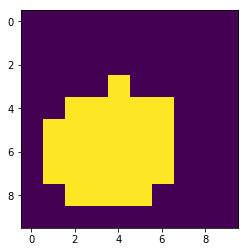

In [3]:
b = Ball(shape=(10,10), radius=(3,3))
l = ConvLSTMCell(input_size=(10,10), input_dim=1, hidden_dim=1, kernel_size=(1,1), bias=True, use_cuda=False)

# Init weights
# l.conv.weight.data.fill_(0)
# l.conv.weight.data[3,0].fill_(1)
# Bias order: (i,f,o,g) where g = C_candidate

h,c = l.init_hidden(batch_size=1)
# (b,t,c,h,w)
inp = Variable(torch.from_numpy(b(sequence_length=1).astype(np.float32)))[0]
# inp = Variable(torch.ones_like(torch.from_numpy(b(sequence_length=1).astype(np.float32))))[np.newaxis]
# inp = inp * 1

h_o, c_o = l(inp, (h,c))

im = c_o[0].data.numpy()
print("Range   {:.4f}  {:.4f}".format(im.min(), im.max()))

plt.close('all')
utils.plotting.plot_synthetic(im);

In [7]:
use_cuda = False

# Ball params
input_size = (10,10)
# Radius uniform distribution
radius = (3,3)

# Network params
input_dim = 1
hidden_dim = [16,8,8]
num_layers = len(hidden_dim)
kernel_size = (5,5)

# Meta params
learning_rate = .01
n_batches = 1000
# TODO: Implement getting multiple batches of Ball() sequences
batch_size = 100
# These sum to sequence length
inputs_seq_len = 5
outputs_seq_len = 5

# Velocity relates to kernel size
b = Ball(shape=input_size, radius=radius, velocity=2, gravity=0, bounce=True)

encoder = ConvLSTM(input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=True, use_cuda=use_cuda)
decoder = ConvLSTM(input_size, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=True, use_cuda=use_cuda)
# Default weights should be ok
decoder_output_conv = torch.nn.Conv2d(in_channels=hidden_dim[-1], out_channels=1, kernel_size=(1,1),
                                     padding=0, bias=True)

optim = torch.optim.Adam(itertools.chain(
    encoder.parameters(),
    decoder.parameters(),
    decoder_output_conv.parameters()), lr=learning_rate)

losses = []

for i_b in range(n_batches):
    # (b, t, c, h, w)
    batch = b(batch_size=batch_size, sequence_length=inputs_seq_len + outputs_seq_len)

    # Targets includes the last input
    inputs, targets = batch[:,:inputs_seq_len], batch[:,-outputs_seq_len:]

    inputs_var = Variable(torch.from_numpy(inputs), requires_grad=True)
    targets_var = Variable(torch.from_numpy(targets))
    
    if use_cuda:
        inputs_var = inputs_var.cuda()
        targets_var = targets_var.cuda()
        
    # TODO: BREAK OUT INTO INFERENCE FUNCTION FROM HERE (args inputs_var, targets_var)

    # Compute encoded state
    # We don't care about outputs other than the last one
    enc_layer_output_list, enc_last_state_list = encoder.forward(inputs_var)

    # Compute time series using encoded state
    # No conditioning on own outputs
    # TODO: Implement forward pass with input=0, e.g. generate zero matrices
    dummy_inputs = Variable(torch.zeros_like(targets_var.data))
    if use_cuda:
        dummy_target_inputs = dummy_target_inputs.cuda()
    # Pass last state
    dec_layer_output_list, dec_last_state_list = decoder.forward(dummy_inputs, hidden_state=enc_last_state_list)
    
    # Get highest layer h
    last_layer_h = dec_layer_output_list[-1]
    # Map to output using 1x1 convolution
    # preds is ordered list of predictions
    # TODO: Test if convolution from all h,c at the same time works better
    preds = [decoder_output_conv(last_layer_h[:,timestep]) for timestep in range(targets.shape[1])]
    # Run through sigmoid to restrict to range [0,1], and make it possible to use cross-entropy loss
#     preds = [torch.nn.functional.hardtanh(p)*.5+.5 for p in preds]
    preds = [torch.sigmoid(p) for p in preds]
    
    # TODO: BREAK OUT INTO INFERENCE FUNCTION UNTIL HERE (return preds)
    
    # Calculate error
    loss_func = torch.nn.MSELoss()
    loss = 0
    for i_t, p in enumerate(preds):
        loss += loss_func(p, targets_var[:,i_t])
    
    # Don't forget to zero the gradient
    optim.zero_grad()
    # Calc all gradients
    loss.backward()
    # Step optimizer
    optim.step()

    print("Batch {:4d} loss: {:.5f} min {: 2.4f} max {: 2.4f}".format(i_b, loss.data[0],
                            min(arr.min().data[0] for arr in preds), max(arr.max().data[0] for arr in preds)))
    losses.append(loss.data[0])


Batch    0 loss: 0.50105 min  0.5009 max  0.5013
Batch    1 loss: 0.48978 min  0.4487 max  0.5050
Batch    2 loss: 0.44024 min  0.2986 max  0.5353
Batch    3 loss: 0.40618 min  0.2856 max  0.5237
Batch    4 loss: 0.39506 min  0.2790 max  0.6236
Batch    5 loss: 0.37776 min  0.2544 max  0.4522
Batch    6 loss: 0.36254 min  0.2340 max  0.4707
Batch    7 loss: 0.34741 min  0.2164 max  0.4891
Batch    8 loss: 0.33630 min  0.2013 max  0.4955
Batch    9 loss: 0.32548 min  0.1875 max  0.4981
Batch   10 loss: 0.31414 min  0.1751 max  0.5000
Batch   11 loss: 0.31170 min  0.1634 max  0.5011
Batch   12 loss: 0.30997 min  0.1524 max  0.5018
Batch   13 loss: 0.31095 min  0.1425 max  0.5041
Batch   14 loss: 0.29300 min  0.1336 max  0.5066
Batch   15 loss: 0.29742 min  0.1255 max  0.5087
Batch   16 loss: 0.29857 min  0.1178 max  0.5108
Batch   17 loss: 0.28173 min  0.1109 max  0.5127
Batch   18 loss: 0.28875 min  0.1046 max  0.5152
Batch   19 loss: 0.28569 min  0.0990 max  0.5177
Batch   20 loss: 0.2

Batch  168 loss: 0.14425 min  0.0094 max  0.8386
Batch  169 loss: 0.13195 min  0.0093 max  0.8393
Batch  170 loss: 0.13647 min  0.0092 max  0.8401
Batch  171 loss: 0.13598 min  0.0091 max  0.8410
Batch  172 loss: 0.13444 min  0.0090 max  0.8418
Batch  173 loss: 0.12913 min  0.0089 max  0.8425
Batch  174 loss: 0.13249 min  0.0088 max  0.8434
Batch  175 loss: 0.13115 min  0.0087 max  0.8443
Batch  176 loss: 0.13122 min  0.0086 max  0.8451
Batch  177 loss: 0.12353 min  0.0085 max  0.8458
Batch  178 loss: 0.12452 min  0.0084 max  0.8467
Batch  179 loss: 0.13041 min  0.0084 max  0.8476
Batch  180 loss: 0.13208 min  0.0082 max  0.8483
Batch  181 loss: 0.13939 min  0.0081 max  0.8491
Batch  182 loss: 0.12972 min  0.0081 max  0.8500
Batch  183 loss: 0.13049 min  0.0080 max  0.8508
Batch  184 loss: 0.13223 min  0.0079 max  0.8514
Batch  185 loss: 0.12756 min  0.0079 max  0.8521
Batch  186 loss: 0.12407 min  0.0078 max  0.8530
Batch  187 loss: 0.12500 min  0.0077 max  0.8537
Batch  188 loss: 0.1

Batch  336 loss: 0.09219 min  0.0027 max  0.9176
Batch  337 loss: 0.09357 min  0.0026 max  0.9179
Batch  338 loss: 0.08779 min  0.0026 max  0.9181
Batch  339 loss: 0.08823 min  0.0026 max  0.9183
Batch  340 loss: 0.08873 min  0.0026 max  0.9186
Batch  341 loss: 0.09537 min  0.0026 max  0.9189
Batch  342 loss: 0.08772 min  0.0026 max  0.9191
Batch  343 loss: 0.08509 min  0.0025 max  0.9193
Batch  344 loss: 0.09290 min  0.0025 max  0.9196
Batch  345 loss: 0.09852 min  0.0025 max  0.9198
Batch  346 loss: 0.09797 min  0.0025 max  0.9200
Batch  347 loss: 0.08799 min  0.0025 max  0.9203
Batch  348 loss: 0.09255 min  0.0025 max  0.9205
Batch  349 loss: 0.09493 min  0.0025 max  0.9207
Batch  350 loss: 0.08969 min  0.0025 max  0.9209
Batch  351 loss: 0.09055 min  0.0025 max  0.9212
Batch  352 loss: 0.09316 min  0.0024 max  0.9214
Batch  353 loss: 0.08635 min  0.0024 max  0.9216
Batch  354 loss: 0.09293 min  0.0024 max  0.9218
Batch  355 loss: 0.08942 min  0.0024 max  0.9221
Batch  356 loss: 0.0

Batch  504 loss: 0.07398 min  0.0012 max  0.9443
Batch  505 loss: 0.09559 min  0.0012 max  0.9444
Batch  506 loss: 0.08476 min  0.0012 max  0.9444
Batch  507 loss: 0.07768 min  0.0012 max  0.9445
Batch  508 loss: 0.08445 min  0.0012 max  0.9446
Batch  509 loss: 0.08550 min  0.0012 max  0.9447
Batch  510 loss: 0.07274 min  0.0012 max  0.9448
Batch  511 loss: 0.09245 min  0.0012 max  0.9449
Batch  512 loss: 0.08987 min  0.0012 max  0.9450
Batch  513 loss: 0.08195 min  0.0012 max  0.9451
Batch  514 loss: 0.08359 min  0.0012 max  0.9452
Batch  515 loss: 0.08231 min  0.0012 max  0.9452
Batch  516 loss: 0.08101 min  0.0012 max  0.9453
Batch  517 loss: 0.07956 min  0.0012 max  0.9454
Batch  518 loss: 0.07969 min  0.0012 max  0.9455
Batch  519 loss: 0.07884 min  0.0011 max  0.9456
Batch  520 loss: 0.07518 min  0.0011 max  0.9456
Batch  521 loss: 0.07078 min  0.0011 max  0.9457
Batch  522 loss: 0.07827 min  0.0011 max  0.9458
Batch  523 loss: 0.08643 min  0.0011 max  0.9459
Batch  524 loss: 0.0

KeyboardInterrupt: 

Lowest: 0.06417


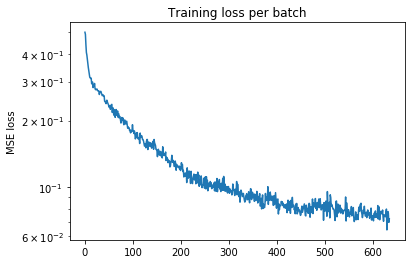

In [8]:
plt.close("all")
fig, ax = plt.subplots()
ax.set_title("Training loss per batch")
ax.set_ylabel('MSE loss')
ax.plot(losses)
ax.set_yscale('log')
print("Lowest: {:.5f}".format(min(losses)))
plt.show()

In [ ]:
batch = 30

inp = [inputs[batch,timestep,0] for timestep in range(inputs.shape[1])]
p = [v[batch,0].data for v in preds]

utils.plotting.plot_synthetic(inp+p, interval=600)